In [1]:
from itertools import combinations
import numpy as np
from z3 import *
import utils
import SAT_constraints

In [2]:
WIDTH = 0
HEIGHT = 1

In [3]:
def coherent_cicuits(bool_vars, dims, n, w, upper_bound):
    constraints = []
    for c in range(1, n + 1):
        c_constraints = []
        height = dims[c - 1][HEIGHT]
        width = dims[c - 1][WIDTH]
        for x in range(w - (width - 1)):
            for y in range(upper_bound - (height - 1)):
                normal = []
                rotated = []
                # Should it be strictly less than or less than and equal here?
                rotation_possible = ((x+height) < w) and ((y+width) < upper_bound) and (width != height)
                for i in range(0, width):
                     for j in range(0, height):
                         normal.append(bool_vars[x+i][y+j][c])
                         if rotation_possible: 
                             rotated.append(bool_vars[x+j][y+i][c])
                
                c_constraints.append(And(normal))
                if len(rotated)>0:
                    c_constraints.append(And(rotated))
        # constraints.append(Or(c_constraints))  
        ex = SAT_constraints.exactly_one_seq(c_constraints, f"coherent_{c}")
        constraints.append(ex)
              
    return And(constraints)



In [4]:
def vlsi_design(w, n, dims, upper_bound):
    s = Solver()
    # upper_bound = sum(dims[:, 1])
    print("Upper bound:", upper_bound)

    # Model the problem
    v = [[[Bool(f"v_{x}_{y}_{c}") for c in range(0, n + 1)] for y in range(upper_bound)] for x in range(w)]
    
    # At most one circuit in each grid cell
    for x in range(w):
        for y in range(upper_bound):
            predicate = v[x][y]
            # print(predicate)
            s.add(SAT_constraints.at_most_one_seq(predicate, f"valid_cell_{x}_{y}"))
    
    # All the circuits must be placed in the grid
    """for c in range(n):
        circuit_area = dims[c, WIDTH] * dims[c, HEIGHT]
        predicate = [v[x][y][c] for x in range(w) for y in range(upper_bound)]
        s.add(exactly_k_seq(predicate, circuit_area, f"valid_placement_{c}"))"""
    
    

    total_white_cells = (upper_bound * w) - sum(dims[:, WIDTH] * dims[:, HEIGHT])
    if total_white_cells > 0:
        predicate = [v[x][y][0] for x in range(w) for y in range(upper_bound)]
        s.add(SAT_constraints.exactly_k_seq(predicate, total_white_cells, f"white_cells_{x}_{y}_{0}"))
    
    s.add(coherent_cicuits(v, dims, n, w, upper_bound))
    
    return s, v


    """if s.check() == sat:
        model = s.model()
        sol = []
        for x in range(w):
            sol.append([])
            for y in range(upper_bound):
                found_circuit = False
                for c in range(n):
                    if model.evaluate(v[x][y][c]):
                        found_circuit = True
                        sol[x].append(c+1)
                if not found_circuit:
                    sol[x].append(0)

        return sol
    else:
        print("Buhu")"""

121
Upper bound: 12
[0, 0, 1, 1, 1, 4, 4, 4, 2, 2, 2, 2]


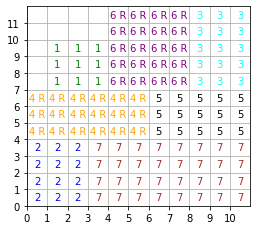

In [5]:
#w = 8
#n = 4
#dims = np.array([[3, 3], [3, 5], [5, 3], [5, 5]])

w = 11
n = 7
dims = np.array([[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]])

print(sum(dims[:, WIDTH] * dims[:, HEIGHT]))

upperbound = sum(dims[:, 1])
l = max(dims[:,1])
l = 12
s, v = vlsi_design(w, n, dims, l)
while(not s.check()==sat):
    print("Trying again with l=", l+1)
    l += 1
    s, v = vlsi_design(w, n, dims, l)



model = s.model()
sol = []


for x in range(w):
    sol.append([])
    for y in range(l):
        found_circuit = False
        for c in range(1, n + 1):
            if model.evaluate(v[x][y][c]):
                found_circuit = True
                sol[x].append(c)
        if not found_circuit:
            sol[x].append(0)
print(sol[1])
utils.visualize_w_color_rotation(sol, w, len(sol[0]), dims)

In [6]:
en = 0
to =0
tre = 0 
fire = 0
a = 0
b =0
c = 0


for elm in sol:
    en += elm.count(1)
    to += elm.count(2)
    tre += elm.count(3)
    fire += elm.count(4)
    a += elm.count(5)
    b += elm.count(6)
    c += elm.count(7)

print(en, to, tre, fire, a, b, c)
    

9 12 15 18 15 20 32


In [7]:
import utils

instance_number = 30
file_path = f"../instances/ins-{instance_number}.txt"

output = utils.read_output(file_path)
w = output[0][0]
n = output[1][0]
dims = output[2:]